Veri başarıyla yüklendi!
Zaman verileri dönüştürülüyor ve temizleniyor...


/tmp/ipython-input-1155285718.py:21: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['time'] = pd.to_datetime(df['time'], unit='s', errors='coerce')


1 adet hatalı/boş satır temizlendi.
Mevsimsel Baseline eklendi.

Model eğitiliyor... (Bu işlem verinin büyüklüğüne göre zaman alabilir)
----------------------------------------
Final R2 Skoru: 0.5655
Final Hata Payı (MAE): 0.3433 kW
----------------------------------------


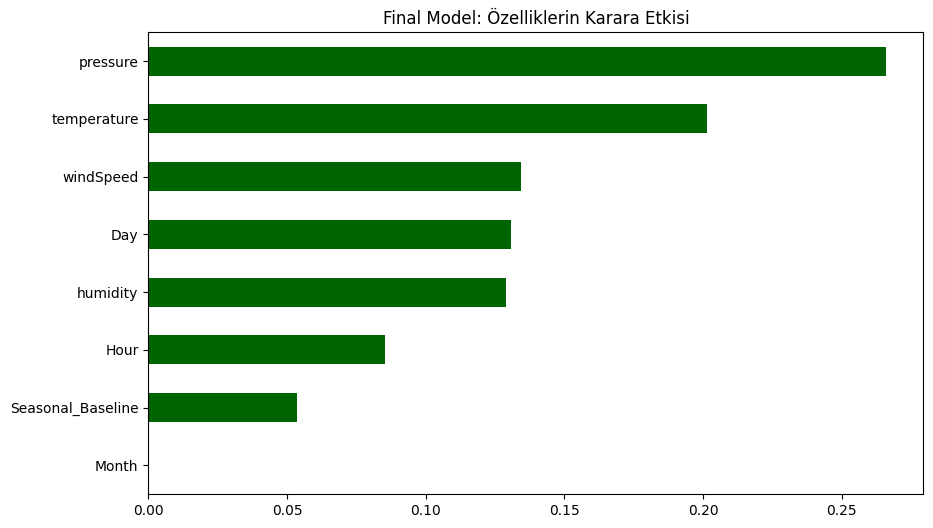

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. VERİ YÜKLEME
try:
    # low_memory=False ve hatalı satırlara karşı önlem
    df = pd.read_csv('Smart Home Dataset.csv', low_memory=False)
    print("Veri başarıyla yüklendi!")
except FileNotFoundError:
    print("Hata: 'Smart Home Dataset.csv' dosyası bulunamadı.")

# 2. VERİ TEMİZLEME (Hata Çözümü)
print("Zaman verileri dönüştürülüyor ve temizleniyor...")

# 'errors=coerce' hatalı değerleri (backslash gibi) NaT (boş) yapar
df['time'] = pd.to_datetime(df['time'], unit='s', errors='coerce')

# NaT (hatalı zamanlar) ve diğer boş satırları tamamen temizleyelim
initial_len = len(df)
df = df.dropna(subset=['time', 'use [kW]'])
cleaned_len = len(df)

print(f"{initial_len - cleaned_len} adet hatalı/boş satır temizlendi.")

# Zaman özelliklerini çıkaralım
df['Hour'] = df['time'].dt.hour
df['Month'] = df['time'].dt.month
df['Day'] = df['time'].dt.dayofweek

df['is_Weekend'] = df['Day'].apply(lambda x: 1 if x >= 5 else 0)

target_col = 'use [kW]'

# 3. MEVSİMSEL PIVOT (Seasonal Baseline)
# "Bu ayda ve bu saatte normal tüketim nedir?"
pivot_table = df.pivot_table(values=target_col,
                             index=['Hour', 'Month', 'is_Weekend'],
                             aggfunc='mean').reset_index()

pivot_table.rename(columns={target_col: 'Seasonal_Baseline'}, inplace=True)

# Pivot bilgisini ana tabloya ekle
df = df.merge(pivot_table, on=['Hour', 'Month'], how='left')

print("Mevsimsel Baseline eklendi.")

# 4. MODEL HAZIRLIĞI
# Önemli: 'Seasonal_Baseline' modelin en büyük yardımcısı olacak.
features = ['Hour', 'Month', 'Day', 'temperature', 'humidity', 'pressure', 'windSpeed', 'Seasonal_Baseline']
X = df[features]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. MODEL EĞİTİMİ
print("\nModel eğitiliyor... (Bu işlem verinin büyüklüğüne göre zaman alabilir)")
# Not: Eğitim çok uzun sürerse n_estimators=20 yapabilirsin
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 6. SONUÇLAR
y_pred = rf_model.predict(X_test)

print("-" * 40)
print(f"Final R2 Skoru: {r2_score(y_test, y_pred):.4f}")
print(f"Final Hata Payı (MAE): {mean_absolute_error(y_test, y_pred):.4f} kW")
print("-" * 40)

# Özellik Önem Sıralaması
plt.figure(figsize=(10,6))
importances = pd.Series(rf_model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', color='darkgreen')
plt.title('Final Model: Özelliklerin Karara Etkisi')
plt.show()